In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score





In [16]:
#load the df from pickle file
vehicle_data_cleaned_all = pd.read_pickle('vehicle_data_cleaned_all.pkl')

In [17]:
#find out all numerical and categorical columns
numerical_columns = vehicle_data_cleaned_all.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = vehicle_data_cleaned_all.select_dtypes(include=['object','category']).columns


# Initialize the OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Apply the OrdinalEncoder to the categorical columns
vehicle_data_cleaned_all[categorical_columns] = ordinal_encoder.fit_transform(vehicle_data_cleaned_all[categorical_columns])



In [18]:
#stratified split by recency

# Ensure the data is sorted by time (assuming 'first_listed' is the time column)
vehicle_data_cleaned_all['first_listed'] = pd.to_datetime(vehicle_data_cleaned_all['first_listed'])
vehicle_data_cleaned_all.sort_values(by='first_listed', inplace=True)

# Create bins for the sale price to ensure similar distribution
vehicle_data_cleaned_all['price_bin'] = pd.qcut(vehicle_data_cleaned_all['sale_price'], q=10, labels=False)

# Perform temporal split ensuring the test data is from the later period
def temporal_split(data, test_size=0.2):
    n_samples = len(data)
    n_test = int(n_samples * test_size)
    
    # Split into training and test based on time
    train_data = data.iloc[:-n_test]
    test_data = data.iloc[-n_test:]
    
    return train_data, test_data

# Perform the temporal split
train_data, test_data = temporal_split(vehicle_data_cleaned_all, test_size=0.2)


In [19]:
# Ensure similar distribution of sale prices in train and test sets
def stratify_price_distribution(train_data, test_data, strat_column):
    # Combine train and test data for stratified splitting
    combined_data = pd.concat([train_data, test_data])
    
    # Perform stratified split on combined data
    strat_split = StratifiedShuffleSplit(n_splits=1, test_size=len(test_data), random_state=42)
    
    for train_index, test_index in strat_split.split(combined_data, combined_data[strat_column]):
        strat_train_data = combined_data.iloc[train_index]
        strat_test_data = combined_data.iloc[test_index]
    
    return strat_train_data, strat_test_data

# Perform stratification to ensure similar sale price distribution
train_data, test_data = stratify_price_distribution(train_data, test_data, strat_column='price_bin')


In [20]:
# explore distribution of price_bin for train and test data
train_data['price_bin'].value_counts(normalize=True).sort_index()

price_bin
0    0.100201
1    0.102267
2    0.103681
3    0.094123
4    0.101834
5    0.099708
6    0.098228
7    0.101167
8    0.099390
9    0.099402
Name: proportion, dtype: float64

In [21]:
test_data['price_bin'].value_counts(normalize=True).sort_index()

price_bin
0    0.100200
1    0.102267
2    0.103681
3    0.094121
4    0.101831
5    0.099705
6    0.098227
7    0.101172
8    0.099393
9    0.099405
Name: proportion, dtype: float64

In [22]:
train_data.columns

Index(['first_listed', 'listing_removed', 'seller_type', 'age_in_mths', 'kms',
       'color', 'state', 'price_drop_count', 'sale_price', 'vehicle_rrp',
       'rv_pct', 'segment', 'sub_segment', 'make', 'model', 'year', 'badge',
       'series', 'vehicle_title', 'model_year', 'body_type',
       'transmission_type', 'drive_type', 'fuel_type', 'wheelbase_type',
       'body_config_type', 'power_kw', 'num_doors', 'num_seats', 'num_gears',
       'capacity_cc', 'days_on_market', 'make_model_series_badge',
       'mean_sale_price_make_model_series_badge', 'log_price_drop_count',
       'log_sale_price', 'log_vehicle_rrp', 'log_power_kw',
       'log_days_on_market', 'log_mean_sale_price_make_model_series_badge',
       'main_color', 'price_bin'],
      dtype='object')

In [9]:
# 1.Train linear regression model on the data
# Drop unnecessary columns before model training
columns_to_keep = ['seller_type', 'age_in_mths', 'kms',
        'state',  
        'segment', 'sub_segment',
        'body_type',
       'transmission_type', 'drive_type', 'fuel_type'
       , 'make_model_series_badge',
        'log_price_drop_count',
       'log_sale_price',  'log_power_kw',
       'log_days_on_market', 'log_mean_sale_price_make_model_series_badge',
       'main_color']
train_data_lr = train_data[columns_to_keep]
test_data_lr = test_data[columns_to_keep]

# One-Hot Encode categorical variables
categorical_columns = train_data_lr.select_dtypes(include=['object','category']).columns
train_data_encoded = pd.get_dummies(train_data_lr, columns=categorical_columns, drop_first=True)
test_data_encoded = pd.get_dummies(test_data_lr, columns=categorical_columns, drop_first=True)


# Define features and target variable
X_train = train_data_encoded.drop(columns=['log_sale_price'])  # Example target variable
y_train = train_data_encoded['log_sale_price']

X_test = test_data_encoded.drop(columns=['log_sale_price'])  # Example target variable
y_test = test_data_encoded['log_sale_price']


# Initialize the Linear Regression model
model_lr = LinearRegression()

# Define the cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define custom scorers for MAE and R²
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Perform cross-validation for MAE
cv_mae_scores = cross_val_score(model_lr, X_train, y_train, cv=kf, scoring=mae_scorer)

# Perform cross-validation for R²
cv_r2_scores = cross_val_score(model_lr, X_train, y_train, cv=kf, scoring=r2_scorer)

print(f'Cross-validated Mean Absolute Error (MAE): {-np.mean(cv_mae_scores)}')
print(f'Cross-validated R²: {np.mean(cv_r2_scores)}')

# Train the model on the entire training set
model_lr.fit(X_train, y_train)

# Predict on the test set
y_pred = model_lr.predict(X_test)

# Evaluate the model on the test set using MAE and R²
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Test Set Mean Absolute Error (MAE): {mae}')
print(f'Test Set R-squared (R²): {r2}')

Cross-validated Mean Absolute Error (MAE): 0.1816114630440369
Cross-validated R²: 0.8379387431273468
Test Set Mean Absolute Error (MAE): 0.18140112370605216
Test Set R-squared (R²): 0.8394076609922614


In [17]:
vehicle_data_cleaned_all.dtypes

first_listed                                   datetime64[ns]
listing_removed                                datetime64[ns]
seller_type                                           float64
age_in_mths                                             int64
kms                                                     int64
color                                                 float64
state                                                 float64
price_drop_count                                        int64
sale_price                                              int64
vehicle_rrp                                           float64
rv_pct                                                float64
segment                                               float64
sub_segment                                           float64
make                                                  float64
model                                                 float64
year                                                    int64
badge   

In [10]:
# 2. train a basic random forrest
#find out all numerical and categorical columns
numerical_columns = vehicle_data_cleaned_all.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = vehicle_data_cleaned_all.select_dtypes(include=['object','category']).columns

# number of unique values in each of categorical columns
vehicle_data_cleaned_all[categorical_columns].nunique()

Series([], dtype: float64)

In [11]:
vehicle_data_cleaned_all.columns

Index(['first_listed', 'listing_removed', 'seller_type', 'age_in_mths', 'kms',
       'color', 'state', 'price_drop_count', 'sale_price', 'vehicle_rrp',
       'rv_pct', 'segment', 'sub_segment', 'make', 'model', 'year', 'badge',
       'series', 'vehicle_title', 'model_year', 'body_type',
       'transmission_type', 'drive_type', 'fuel_type', 'wheelbase_type',
       'body_config_type', 'power_kw', 'num_doors', 'num_seats', 'num_gears',
       'capacity_cc', 'days_on_market', 'make_model_series_badge',
       'mean_sale_price_make_model_series_badge', 'log_price_drop_count',
       'log_sale_price', 'log_vehicle_rrp', 'log_power_kw',
       'log_days_on_market', 'log_mean_sale_price_make_model_series_badge',
       'main_color', 'price_bin'],
      dtype='object')

In [8]:
# Define features and target variable
columns_to_keep = [ 'seller_type', 'age_in_mths', 'kms', 'state',  'sale_price', 
        'segment', 'sub_segment', 'body_type',
       'transmission_type', 'drive_type', 'power_kw', 
        'days_on_market', 'make_model_series_badge',
       'mean_sale_price_make_model_series_badge', 
       'main_color']
train_data_rf = train_data[columns_to_keep]
test_data_rf = test_data[columns_to_keep]


# Define features and target variable
X_train = train_data_rf.drop(columns=['sale_price'])  # Example target variable
y_train = train_data_rf['sale_price']

X_test = test_data_rf.drop(columns=['sale_price'])  # Example target variable
y_test = test_data_rf['sale_price']


In [12]:
# Initialize the Random Forest model
model_rf = RandomForestRegressor()


In [14]:


# Define the cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define custom scorers for MAE and R²
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Perform cross-validation for MAE
cv_mae_scores = cross_val_score(model_rf, X_train, y_train, cv=kf, scoring=mae_scorer)

# Perform cross-validation for R²
cv_r2_scores = cross_val_score(model_rf, X_train, y_train, cv=kf, scoring=r2_scorer)

print(f'Cross-validated Mean Absolute Error (MAE): {-np.mean(cv_mae_scores)}')
print(f'Cross-validated R²: {np.mean(cv_r2_scores)}')


KeyboardInterrupt: 

In [14]:

# Train the model on the entire training set
model_rf.fit(X_train, y_train)

# Predict on the test set
y_pred = model_rf.predict(X_test)

# Evaluate the model on the test set using MAE and R²
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Test Set Mean Absolute Error (MAE): {mae}')
print(f'Test Set R-squared (R²): {r2}')

KeyboardInterrupt: 

<Axes: >

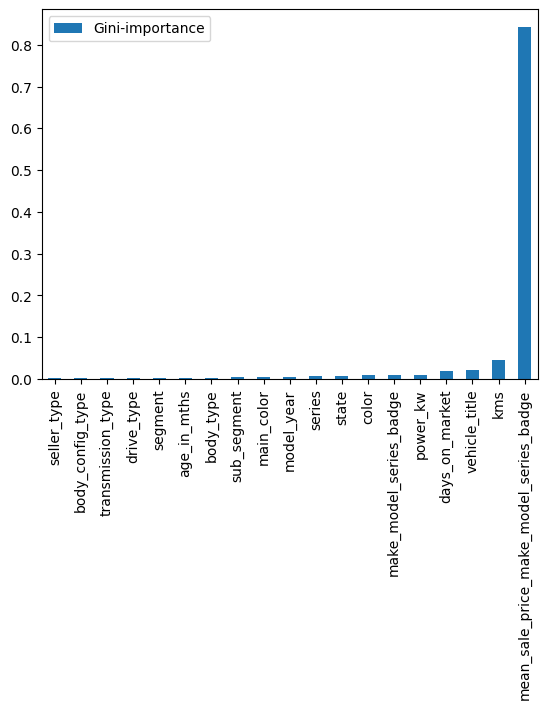

In [20]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, model_rf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90)

In [21]:
# feature importance alternative, shap value
import shap

# Assuming xgb_model is your trained XGBoost model
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

/opt/anaconda3/envs/development/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
#xgboost model






# Define features and target variable
X_train = train_data.drop(columns=['sale_price', 'log_sale_price', 'rv_pct', 'first_listed', 'listing_removed', 'vehicle_title', 'color', 'price_bin'])  # Example target variable
y_train = train_data['sale_price']
#generate the same for test data
X_test = test_data.drop(columns=['sale_price', 'log_sale_price', 'rv_pct', 'first_listed', 'listing_removed', 'vehicle_title', 'color', 'price_bin'])  # Example target variable
y_test = test_data['sale_price']





# Initialize the XGBoost model
model = xgb.XGBRegressor(enable_categorical=True, eval_metric='mae',random_state=42)

# Define the cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define custom scorers for MAE and R²
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Perform cross-validation for MAE
cv_mae_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=mae_scorer)

# Perform cross-validation for R²
cv_r2_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=r2_scorer)

print(f'Cross-validated Mean Absolute Error (MAE): {-np.mean(cv_mae_scores)}')
print(f'Cross-validated R²: {np.mean(cv_r2_scores)}')

# Train the model on the entire training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model on the test set using MAE and R²
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Test Set Mean Absolute Error (MAE): {mae}')
print(f'Test Set R-squared (R²): {r2}')

Cross-validated Mean Absolute Error (MAE): 3216.394318561007
Cross-validated R²: 0.9077515602111816
Test Set Mean Absolute Error (MAE): 3195.311937007295
Test Set R-squared (R²): 0.9112476706504822


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

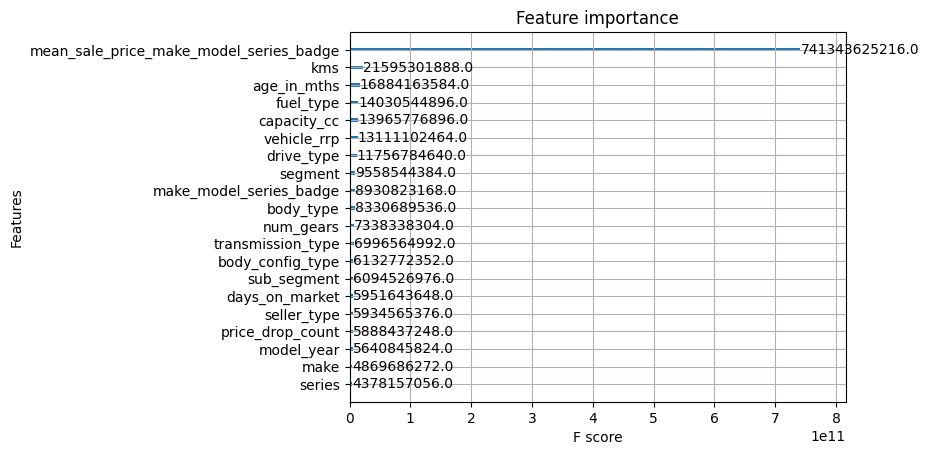

In [11]:
#feature importance
# ”gain” is the average gain of splits which use the feature
xgb.plot_importance(model, importance_type='gain', max_num_features=20)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

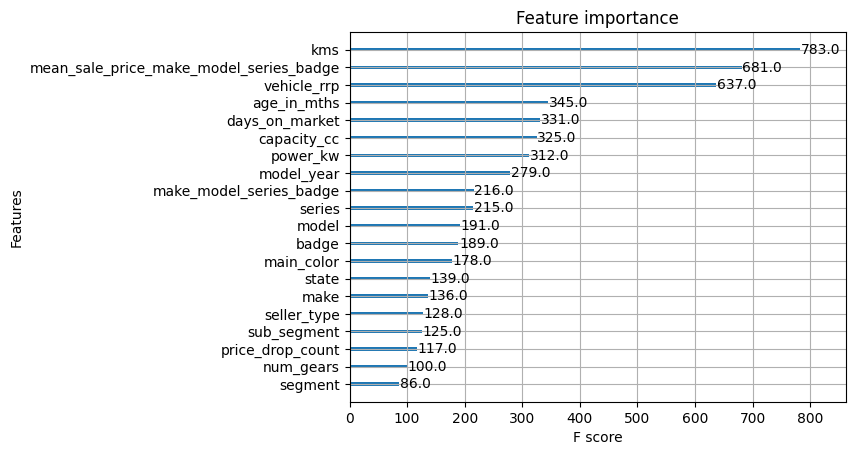

In [12]:
#feature importance
xgb.plot_importance(model, importance_type='weight', max_num_features=20)

/opt/anaconda3/envs/development/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


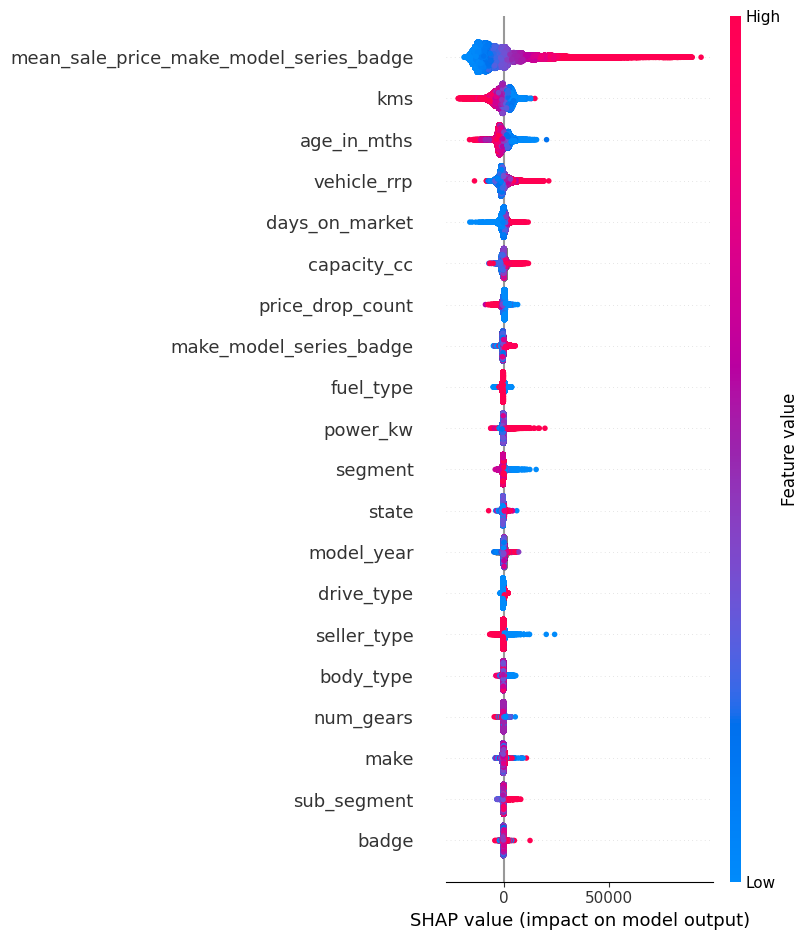

In [13]:
# feature importance alternative, shap value
import shap

# Assuming xgb_model is your trained XGBoost model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

                                        feature  importance  percentage
27      mean_sale_price_make_model_series_badge    0.775457   77.545677
2                                           kms    0.021088    2.108812
1                                   age_in_mths    0.017264    1.726356
17                                    fuel_type    0.017033    1.703313
16                                   drive_type    0.015536    1.553632
24                                  capacity_cc    0.015361    1.536107
5                                   vehicle_rrp    0.013135    1.313451
26                      make_model_series_badge    0.010800    1.080012
23                                    num_gears    0.009166    0.916639
6                                       segment    0.008215    0.821548
13                                   model_year    0.007387    0.738684
7                                   sub_segment    0.006792    0.679217
4                              price_drop_count    0.006363    0

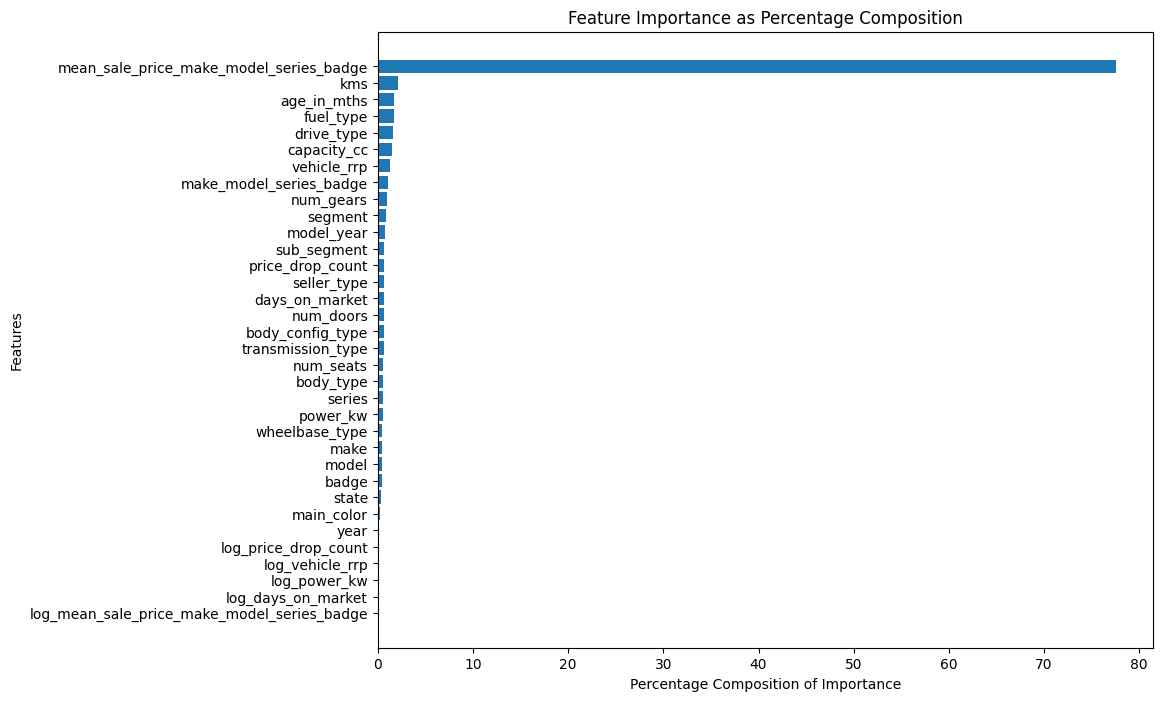

In [25]:
# Extract feature importances
importances = model.feature_importances_

# Get feature names
feature_names = X_train.columns

# Create a DataFrame for the feature importances
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Calculate percentage composition
feature_importances['percentage'] = 100 * (feature_importances['importance'] / feature_importances['importance'].sum())

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Display the feature importances
print(feature_importances)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['feature'], feature_importances['percentage'])
plt.xlabel('Percentage Composition of Importance')
plt.ylabel('Features')
plt.title('Feature Importance as Percentage Composition')
plt.gca().invert_yaxis()
plt.show()